In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import product
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm 
import sklearn.metrics as skmetrics
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.api import VAR # easier for order selection
from statsmodels.tsa.statespace.varmax import VARMAX # easier for forecasting
from prophet import Prophet
import warnings                               
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("train.csv")
df.tail(5)

,Datetime,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
77197,2020-03-15 23:10:00+00:00,272.852287,23.500851,43.740629,-0.524250,-0.108540,-0.108540,63.668076,56.801410,1029.697556,64.904780,64.000634,35.012077,35.406250,182.0,54.889963,9.243551,2.0,182.0,5.156629
77198,2020-03-15 23:20:00+00:00,295.675931,23.409183,43.529209,-0.684376,-0.168882,-0.168882,63.361840,56.551527,1032.996150,64.109157,63.189782,35.004216,35.280933,182.0,60.673948,9.269149,2.0,182.0,5.257433
77199,2020-03-15 23:30:00+00:00,295.127333,23.336964,43.331115,-0.743521,-0.292512,-0.292512,63.156279,56.393276,1031.935870,63.740245,62.798514,35.003815,35.140925,182.0,59.551241,9.252811,2.0,182.0,5.188531
77200,2020-03-15 23:40:00+00:00,342.942216,23.310323,43.169442,-0.955621,-0.516466,-0.516466,63.191997,56.273992,1047.165900,63.657965,62.699627,35.003815,35.093750,182.0,69.460091,9.385111,2.0,182.0,5.408458
77201,2020-03-15 23:50:00+00:00,374.401860,23.297918,43.050359,-0.997635,-0.557849,-0.557849,63.424068,56.175566,1071.970544,63.752799,62.803517,35.003815,35.039062,182.0,75.836758,9.609502,2.0,182.0,5.637122


In [4]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
daily = df.groupby(pd.Grouper(freq='D', key='Datetime')).mean()
#daily.reset_index(inplace=True)
daily['ActivePower'].interpolate(method='linear', inplace=True)
daily['AmbientTemperatue'].interpolate(method='linear', inplace=True)
daily['NacellePosition'].interpolate(method='linear', inplace=True)
daily['ReactivePower'].interpolate(method='linear', inplace=True)
#daily['RotorRPM'].interpolate(method='linear', inplace=True)


In [5]:
daily.head(10)

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,366.223561,25.528849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.727612,74.042120,NaN,NaN,276.727612,5.263797
2018-01-02 00:00:00+00:00,462.550740,25.357526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.105603,93.555723,NaN,NaN,274.105603,5.390719
2018-01-03 00:00:00+00:00,454.417752,24.379363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.369130,91.627843,NaN,NaN,286.369130,5.295225
2018-01-04 00:00:00+00:00,369.952190,24.912347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,284.445471,74.360621,NaN,NaN,284.445471,5.094994
2018-01-05 00:00:00+00:00,319.446595,23.535679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292.013293,64.366148,NaN,NaN,292.013293,4.915224
2018-01-06 00:00:00+00:00,337.470688,21.278356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,333.250000,68.641368,NaN,NaN,333.250000,5.464902
2018-01-07 00:00:00+00:00,599.368907,22.508058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,306.903696,121.557028,NaN,NaN,NaN,NaN
2018-01-08 00:00:00+00:00,861.267127,23.737759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.557391,174.472688,NaN,NaN,280.557391,6.886447
2018-01-09 00:00:00+00:00,514.967905,23.565185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,278.533693,104.224432,NaN,NaN,278.533693,5.679249


In [6]:
test = daily[-15:]
train = daily[:-15]
len(train) + len(test) == len(daily)

True

In [7]:
dftest = adfuller(train["ActivePower"], autolag='AIC')
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print(dfoutput)

Test Statistic   -3.206282
p-value           0.019624
dtype: float64


<AxesSubplot:xlabel='Datetime'>

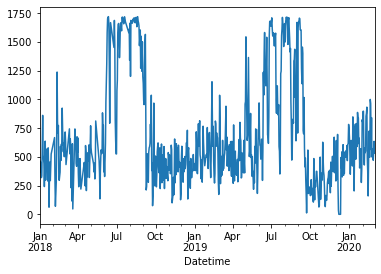

In [8]:
train.ActivePower.plot()

In [9]:
train

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,366.223561,25.528849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.727612,74.042120,NaN,NaN,276.727612,5.263797
2018-01-02 00:00:00+00:00,462.550740,25.357526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.105603,93.555723,NaN,NaN,274.105603,5.390719
2018-01-03 00:00:00+00:00,454.417752,24.379363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.369130,91.627843,NaN,NaN,286.369130,5.295225
2018-01-04 00:00:00+00:00,369.952190,24.912347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,284.445471,74.360621,NaN,NaN,284.445471,5.094994
2018-01-05 00:00:00+00:00,319.446595,23.535679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292.013293,64.366148,NaN,NaN,292.013293,4.915224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-25 00:00:00+00:00,516.014263,27.342190,42.747846,1.115362,1.571159,1.571159,63.529065,55.708862,1152.188781,66.989596,66.260159,37.282285,38.629440,179.154689,88.983902,10.328576,2.303030,179.154689,5.584996
2020-02-26 00:00:00+00:00,470.661244,27.625525,42.870164,-0.360082,0.211408,0.211408,65.609051,57.623263,1158.356614,66.185684,65.437812,35.502224,39.156773,172.022451,95.088928,10.385612,2.000000,172.022451,5.637419
2020-02-27 00:00:00+00:00,541.003574,27.439414,43.347578,0.723516,1.184950,1.184950,64.796991,56.730206,1192.237009,67.452270,66.789682,36.055745,38.783614,169.165909,108.164756,10.696756,12.198529,169.165909,5.638373


In [10]:
chosen_train = train[["ActivePower","AmbientTemperatue","NacellePosition","ReactivePower"]]
chosen_test = test[["ActivePower","AmbientTemperatue","NacellePosition","ReactivePower"]]

In [11]:
model = VAR(chosen_train)

In [12]:
x= model.select_order()
x.summary()

,AIC,BIC,FPE,HQIC
0,31.33,31.35,4.038e+13,31.34
1,24.41,24.53*,3.998e+10,24.46
2,24.35,24.56,3.744e+10,24.43*
3,24.34,24.65,3.721e+10,24.46
4,24.30,24.71,3.580e+10,24.46
5,24.29,24.80,3.552e+10,24.49
6,24.27*,24.88,3.478e+10*,24.50
7,24.29,24.99,3.536e+10,24.56
8,24.29,25.09,3.540e+10,24.60
9,24.32,25.21,3.637e+10,24.66


In [13]:
var_model = VARMAX(chosen_train, order=(6, 0), enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                                      Statespace Model Results                                                      
Dep. Variable:     ['ActivePower', 'AmbientTemperatue', 'NacellePosition', 'ReactivePower']   No. Observations:                  790
Model:                                                                               VAR(6)   Log Likelihood              -13963.826
                                                                                + intercept   AIC                          28147.652
Date:                                                                      Sun, 11 Dec 2022   BIC                          28661.576
Time:                                                                              15:38:39   HQIC                         28345.196
Sample:                                                                          01-01-2018                                         
                                                                     

In [58]:
df = pd.read_csv("train.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
daily = df.groupby(pd.Grouper(freq='D', key='Datetime')).mean()
#daily.reset_index(inplace=True)
daily['ActivePower'].interpolate(method='linear', inplace=True)
daily['AmbientTemperatue'].interpolate(method='linear', inplace=True)
daily['NacellePosition'].interpolate(method='linear', inplace=True)
daily['ReactivePower'].interpolate(method='linear', inplace=True)

chosen_train = daily[["ActivePower","AmbientTemperatue","NacellePosition","ReactivePower"]]
var_model = VARMAX(chosen_train, order=(6, 0), enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
n_forecast = 15
predict = fitted_model.get_prediction(start=len(chosen_train),end=len(chosen_train) + n_forecast-1)#start="1989-07-01",end='1999-01-01')
predictions=predict.predicted_mean

In [59]:
predictions

,ActivePower,AmbientTemperatue,NacellePosition,ReactivePower
2020-03-16 00:00:00+00:00,749.565453,28.148148,169.420938,115.856408
2020-03-17 00:00:00+00:00,711.582001,28.190956,177.670626,111.895116
2020-03-18 00:00:00+00:00,699.439594,28.339023,182.640334,107.518580
2020-03-19 00:00:00+00:00,682.820641,28.714237,180.335650,100.732522
2020-03-20 00:00:00+00:00,695.530055,28.754028,180.147568,100.728673
2020-03-21 00:00:00+00:00,705.881948,28.635419,181.914985,101.441414
2020-03-22 00:00:00+00:00,709.436066,28.528856,183.838994,101.487401
2020-03-23 00:00:00+00:00,710.217509,28.439365,185.466731,101.470204
2020-03-24 00:00:00+00:00,706.286897,28.388310,186.588155,100.064852
2020-03-25 00:00:00+00:00,703.060463,28.435444,187.227084,98.434953


In [16]:
chosen_test["ActivePower_Prediction"] = predictions["ActivePower"]

In [56]:
df = pd.read_csv("train.csv")
df=df[['Datetime','ActivePower']]
df['Datetime'] = pd.to_datetime(df['Datetime'],format='%Y-%m-%d')
df['Datetime']=df['Datetime'].apply(lambda x:x.date)
df=pd.DataFrame(df.groupby('Datetime').mean()['ActivePower'])
def rmse_cv(ts, sarima_order, seasonal_order, val_size, rw_size, cv):
    split = len(ts) - rw_size * cv
    train, val = ts[:split], ts[split:]
    predictions = []
    total_rmse = 0
    for i in range(cv):
        model = SARIMAX(ts[:split + rw_size * i], order=sarima_order,
            seasonal_order=seasonal_order, trend='c',initialization='approximate_diffuse')
        res = model.fit(disp=0)
        y_pred = np.asanyarray(res.forecast(steps=val_size))
        predictions.extend(y_pred)
        y_true = val[rw_size * i:rw_size * i + val_size]
        total_rmse += np.sqrt(skmetrics.mean_squared_error(y_true, y_pred))
    
    return total_rmse / cv, predictions
rmses_sarima, sarima_preds = rmse_cv(df, (0, 0, 3), (3, 1, 1, 7), 15, 15, 5)

sarima_final_model = SARIMAX(df, order=(0, 0, 3),
            seasonal_order=(3, 1, 1, 7), trend='c',initialization='approximate_diffuse')
res = sarima_final_model.fit(disp=0)
sarima_final_preds = np.asanyarray(res.forecast(15))



In [119]:
df = pd.read_csv("train.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['y'] = df['ActivePower']
df_daily = df.groupby(pd.Grouper(freq='D', key='Datetime')).mean().reset_index()
df_daily['ds'] = df_daily['Datetime'].dt.tz_localize(None)
#train_daily, test_daily = df_daily.iloc[:-15], df_daily.iloc[-15:]
#test_daily['y'].fillna((3.37470688e+02+8.61267127e+02)/2, inplace=True)
#test_daily['y'].dropna()
p = Prophet(seasonality_mode='multiplicative', seasonality_prior_scale=7)
p.fit(df_daily)
future = p.make_future_dataframe(periods=15)
forecast_prophet = p.predict(future)


16:45:36 - cmdstanpy - INFO - Chain [1] start processing
16:45:36 - cmdstanpy - INFO - Chain [1] done processing


206.98576944012302

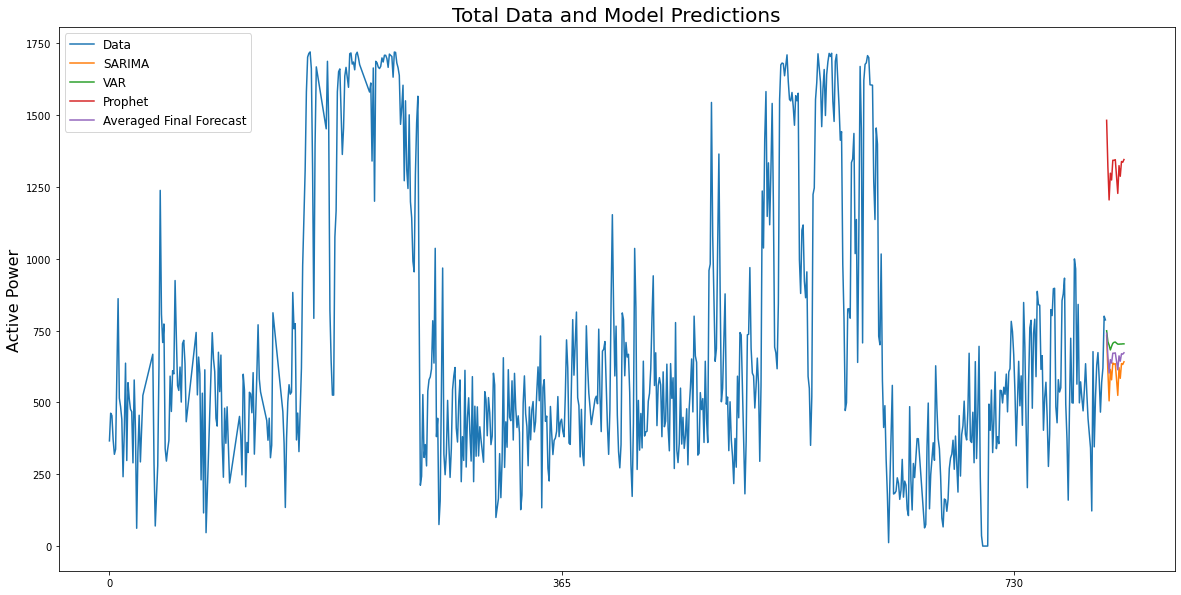

In [134]:
avged = np.add(sarima_final_preds, predictions.ActivePower.values)/2

plt.figure(figsize=(20,10))
plt.plot(range(805),
         np.concatenate([train.ActivePower, test.ActivePower]), label="Data")
plt.plot(range(805,820), sarima_final_preds, label = 'SARIMA')
plt.plot(range(805,820),predictions.ActivePower, label='VAR')
plt.plot(range(805,820), forecast_prophet['yhat'].iloc[-15:], label = 'Prophet')
plt.plot(range(805,820), avged, label = 'Averaged Final Forecast')
plt.title('Total Data and Model Predictions', size = '20')
#plt.gca().get_xaxis().set_visible(False)
plt.xticks(range(0,830, 365))

plt.ylabel('Active Power', size = 16)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [131]:
forecast_prophet['ds'].iloc[-15:]

805   2020-03-16
806   2020-03-17
807   2020-03-18
808   2020-03-19
809   2020-03-20
810   2020-03-21
811   2020-03-22
812   2020-03-23
813   2020-03-24
814   2020-03-25
815   2020-03-26
816   2020-03-27
817   2020-03-28
818   2020-03-29
819   2020-03-30
Name: ds, dtype: datetime64[ns]

In [133]:
pd.DataFrame(avged, index=forecast_prophet['ds'].iloc[-15:]).to_csv('Time_Series_Forecasts')